In [1]:
from matplotlib import pyplot as plt
import numpy as np
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, resize, downscale_local_mean
import math
import os
import numpy as np

import sigpy as sp
import sigpy.plot as pl
import seaborn as sns
sns.set(style='darkgrid', palette='Set2')
from cmcrameri import cm

from dipy.segment.mask import median_otsu
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import numpy as np
import nrrd
import pingouin as pg
import scikit_posthocs as sp

from scipy.signal import argrelextrema

import sys
sys.path.append("/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python")
from mystic_mrpy.Data_Import.Diffusion   import *
from mystic_mrpy.Data_Sorting.Diffusion  import *
from mystic_mrpy.Diffusion.DWI  import *
from mystic_mrpy.Diffusion.Gibbs         import *
from mystic_mrpy.Diffusion.Registration  import *
from mystic_mrpy.Diffusion.Rejection     import *
from mystic_mrpy.Diffusion.Respiratory   import *
from mystic_mrpy.Diffusion.Averaging     import *
from mystic_mrpy.Diffusion.Denoising     import *
from mystic_mrpy.Diffusion.Interpolation import *
from mystic_mrpy.Diffusion.Segmentation_Matrix_DTI import *
from mystic_mrpy.Diffusion.DTI import *
from mystic_mrpy.Diffusion.cDTI import *

import numpy as np
import matplotlib.pyplot as plt

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
from PIL import Image, ImageFilter
def get_edge(img):
    #define the vertical filter
    vertical_filter = [[-1,-2,-1], [0,0,0], [1,2,1]]

    #define the horizontal filter
    horizontal_filter = [[-1,0,1], [-2,0,2], [-1,0,1]]

    #get the dimensions of the image
    n,m = img.shape

    #initialize the edges image
    edges_img = img.copy()

    #loop over all pixels in the image
    for row in range(3, n-2):
        for col in range(3, m-2):

            #create little local 3x3 box
            local_pixels = img[row-1:row+2, col-1:col+2]

            #apply the vertical filter
            vertical_transformed_pixels = vertical_filter*local_pixels
            #remap the vertical score
            vertical_score = vertical_transformed_pixels.sum()/4

            #apply the horizontal filter
            horizontal_transformed_pixels = horizontal_filter*local_pixels
            #remap the horizontal score
            horizontal_score = horizontal_transformed_pixels.sum()/4

            #combine the horizontal and vertical scores into a total edge score
            edge_score = (vertical_score**2 + horizontal_score**2)**.5

            #insert this edge score into the edges image
            edges_img[row, col] = edge_score*2

    #remap the values in the 0-1 range in case they went out of bounds
    edges_img = edges_img/edges_img.max()
    edges_img[edges_img>0] = 1
    edges_img.dtype = float
    edges_img[edges_img ==0] = 'nan'
    return edges_img

In [3]:
# Load in Spatial Gradients

volunteers=[1,2,3,4,5,6,7,8,9,10]
slope_m0 = np.zeros((128,100,3,4,5,10))
slope_m1 = np.zeros((128,100,3,4,5,10))
slope_m2 = np.zeros((128,100,3,4,5,10))

for vv in range(10):

    inpath = '/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Projects/Phase/Data/Heart/V00' + str(volunteers[vv]) + '/DWI/'
    
    mask_files_LV = [_ for _ in os.listdir(inpath) if _.startswith('LV')]
    mask_files_BP = [_ for _ in os.listdir(inpath) if _.startswith('BP')]
    
    mask_files_LV.sort()
    mask_files_BP.sort()
    
    
    mm = 0
    for num in range(1,7,2):
        mask_LV,affine, voxsize = load_nifti(os.path.join(inpath, mask_files_LV[mm]), return_voxsize=True)
        mask_BP,affine, voxsize = load_nifti(os.path.join(inpath, mask_files_BP[mm]), return_voxsize=True)
        
        mask_LV_rep = np.tile(mask_LV[:,:,:,np.newaxis,np.newaxis],(1,1,1,4,5))
        mask_BP_rep = np.tile(mask_BP[:,:,:,np.newaxis,np.newaxis],(1,1,1,4,5))
        mask_rep = (mask_LV_rep - mask_BP_rep).astype(np.float32)
        
        mask_rep[mask_rep ==0] = np.nan
        if mask_rep.shape[0] ==100:
            mask_rep = mask_rep.transpose(1,0,2,3,4)
        if num == 1:
            M0_mask = mask_rep
        if num == 3:
            M1_mask = mask_rep
        if num == 5:
            M2_mask = mask_rep


    savename = os.path.join(inpath,'M0_vgrad.npy')
    vgrad = np.load(savename)
    slope_m0[:,:,:,:,:,vv] = np.sqrt(vgrad[0]**2 + vgrad[1]**2) * M0_mask

    savename = os.path.join(inpath,'M1_vgrad.npy')
    vgrad = np.load(savename)
    slope_m1[:,:,:,:,:,vv] = np.sqrt(vgrad[0]**2 + vgrad[1]**2)* M1_mask

    savename = os.path.join(inpath,'M2_vgrad.npy')
    vgrad = np.load(savename)
    slope_m2[:,:,:,:,:,vv] = np.sqrt(vgrad[0]**2 + vgrad[1]**2)* M2_mask
    


In [4]:
atten_m0 = abs(np.sinc((np.nanmean(slope_m0,axis = -2)) *2*2/2))
atten_m1 = abs(np.sinc((np.nanmean(slope_m1,axis = -2)) *2*2/2))
atten_m2 = abs(np.sinc((np.nanmean(slope_m2,axis = -2)) *2*2/2))

atten_m0.shape

<ipython-input-4-9531b6550629>:1: RuntimeWarning: Mean of empty slice
  atten_m0 = abs(np.sinc((np.nanmean(slope_m0,axis = -2)) *2*2/2))
<ipython-input-4-9531b6550629>:2: RuntimeWarning: Mean of empty slice
  atten_m1 = abs(np.sinc((np.nanmean(slope_m1,axis = -2)) *2*2/2))
<ipython-input-4-9531b6550629>:3: RuntimeWarning: Mean of empty slice
  atten_m2 = abs(np.sinc((np.nanmean(slope_m2,axis = -2)) *2*2/2))


(128, 100, 3, 4, 10)

In [5]:
from dipy.segment.mask import median_otsu
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import numpy as np

M0_mag = np.zeros((128,100,3,4,5,10))
M1_mag = np.zeros((128,100,3,4,5,10))
M2_mag = np.zeros((128,100,3,4,5,10))

M0_phs = np.zeros((128,100,3,4,5,10))
M1_phs = np.zeros((128,100,3,4,5,10))
M2_phs = np.zeros((128,100,3,4,5,10))

M0_mask_new = np.zeros((128,100,3,10))
M1_mask_new = np.zeros((128,100,3,10))
M2_mask_new = np.zeros((128,100,3,10))

for volunteer in range(1,11):
    # inpath = '/Volumes/T7/phase_paper/Heart/V00' + volunteer + '/DWI'
    inpath = '/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Projects/Phase/Data/Heart/V00' + str(volunteer) + '/DWI'

    name = inpath.split('/')
    namejoin = '/'.join(name[:-1])

    nii_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.nii')]
    bval_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvals')]
    bvec_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvecs')]
    nii_files.sort()
    bval_files.sort()
    bvec_files.sort()


    mask_files_LV = [_ for _ in os.listdir(inpath) if _.startswith('LV')]
    mask_files_BP = [_ for _ in os.listdir(inpath) if _.startswith('BP')]

    mask_files_LV.sort()
    mask_files_BP.sort()

    mm = 0
    for num in range(1,7,2):

    # inpath = '/Volumes/T7/phase_paper/Heart/V00' + volunteer + '/DWI'
        data,affine, voxsize = load_nifti(os.path.join(inpath, nii_files[num]), return_voxsize=True)
        bvals = np.loadtxt(os.path.join(inpath,bval_files[num])) 
        bvecs = np.loadtxt(os.path.join(inpath,bvec_files[num]))
        
        mask_LV,affine, voxsize = load_nifti(os.path.join(inpath, mask_files_LV[mm]), return_voxsize=True)
        mask_BP,affine, voxsize = load_nifti(os.path.join(inpath, mask_files_BP[mm]), return_voxsize=True)

        data1,bvals_sort,bvecs_sort = stacked2sorted(data,bvals,bvecs.T)

        ims = data1
        mag = abs(ims)
        phs = np.angle(ims)
        
        mask_LV_rep = np.tile(mask_LV[:,:,:,np.newaxis,np.newaxis],(1,1,1,4,5))
        mask_BP_rep = np.tile(mask_BP[:,:,:,np.newaxis,np.newaxis],(1,1,1,4,5))
        mask_rep = (mask_LV_rep - mask_BP_rep).astype(np.float32)
        
        mask_rep[mask_rep ==0] = np.nan
        adc_avg = DWI_recon(mag,bvals_sort,bvecs_sort)
        

        im = np.exp(1j*phs)
        
        
        if mag.shape[0] == 100:
            print('Dim',vv)
            mag = mag.transpose(1,0,2,3,4)
            phs = phs.transpose(1,0,2,3,4)
            mask_rep = mask_rep.transpose(1,0,2,3,4)
            adc_avg[0]['ADC'] = adc_avg[0]['ADC'].transpose(1,0,2)

        
        if num == 1:
            M0_mag[:,:,:,:,:,volunteer-1] = mag #* mask_rep
            M0_phs[:,:,:,:,:,volunteer-1]= phs #*mask_rep
            M0_mask_new[:,:,:,volunteer-1] = mask_rep[:,:,:,0,0] #*mask_rep

        if num == 3:
            M1_mag[:,:,:,:,:,volunteer-1] = mag #* mask_rep
            M1_phs[:,:,:,:,:,volunteer-1] = phs #*mask_rep
            M1_mask_new[:,:,:,volunteer-1] = mask_rep[:,:,:,0,0] #*mask_rep
    
        if num == 5:
            M2_mag[:,:,:,:,:,volunteer-1]= mag #* mask_rep
            M2_phs[:,:,:,:,:,volunteer-1] = phs #*mask_rep
            M2_mask_new[:,:,:,volunteer-1] = mask_rep[:,:,:,0,0] #*mask_rep
            
        mm = mm +1


# One data structure of complex dataset 
im_M0 = M0_mag * np.exp(1j*M0_phs)
im_M1 = M1_mag * np.exp(1j*M1_phs)
im_M2 = M2_mag * np.exp(1j*M2_phs)

M0_mask = M0_mask_new
M1_mask = M1_mask_new
M2_mask = M2_mask_new


del M0_mag,M1_mag,M2_mag
del M0_phs,M1_phs,M2_phs

/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python/mystic_mrpy/Diffusion/DWI.py:45: RuntimeWarning: divide by zero encountered in divide
  D_xx                             = -(1 / b) * np.log(S_x / S_0)                                                             # Calculate x diffusion coefficient
/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python/mystic_mrpy/Diffusion/DWI.py:45: RuntimeWarning: invalid value encountered in divide
  D_xx                             = -(1 / b) * np.log(S_x / S_0)                                                             # Calculate x diffusion coefficient
/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python/mystic_mrpy/Diffusion/DWI.py:45: RuntimeWarning: divide by zero encountered in log
  D_xx                             = -(1 / b) * np.log(S_x / S_0)                                                             # Calculate x diffusion coefficient
/Users/arielhannum/Documents/Stanford/CMR-Setsompop/C

Dim 9
Dim 9
Dim 9
Dim 9
Dim 9
Dim 9
Dim 9
Dim 9
Dim 9


# Complex Averaging and Magnitdue Averaging

In [6]:
sys.path.append("../../")
from DataSorting import *
from Averaging import *
from DWI import *
from Colormaps import *

cDTI_cmaps     = cDTI_Colormaps_Generator()


In [64]:



averaged_complex_M0 = np.zeros((128,100,3,4,10),dtype = 'complex128')
averaged_complex_M1 = np.zeros((128,100,3,4,10),dtype = 'complex128')
averaged_complex_M2 = np.zeros((128,100,3,4,10),dtype = 'complex128')

adc_complex_M0 = np.zeros((128,100,3,10))
adc_complex_M1 = np.zeros((128,100,3,10))
adc_complex_M2 = np.zeros((128,100,3,10))

for vv in range(10):
    for ii in range(1):
        [avg,_,_,_ ]= average(im_M0[:,:,:,:,:,vv],[],[],operation_type='Complex')
        averaged_complex_M0[:,:,:,:,vv] = np.squeeze(avg)
        
        adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)
        adc_complex_M0[:,:,:,vv] = adc[0]['ADC']

        [avg,_,_,_ ]= average(im_M1[:,:,:,:,:,vv],[],[],operation_type='Complex')
        averaged_complex_M1[:,:,:,:,vv] = np.squeeze(avg)

        adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)
        adc_complex_M1[:,:,:,vv] = adc[0]['ADC']

        [avg,_,_,_ ]= average(im_M2[:,:,:,:,:,vv],[],[],operation_type='Complex')
        averaged_complex_M2[:,:,:,:,vv] = np.squeeze(avg)

        adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)
        adc_complex_M2[:,:,:,vv] = adc[0]['ADC']




averaged_mag_M0 = np.zeros((128,100,3,4,10),dtype = 'complex128')
averaged_mag_M1 = np.zeros((128,100,3,4,10),dtype = 'complex128')
averaged_mag_M2 = np.zeros((128,100,3,4,10),dtype = 'complex128')

adc_mag_M0 = np.zeros((128,100,3,10))
adc_mag_M1 = np.zeros((128,100,3,10))
adc_mag_M2 = np.zeros((128,100,3,10))
"""
for vv in range(10):
    for ii in range(1):
        [avg,_,_,_ ]= average(im_M0[:,:,:,:,:,vv],[],[],operation_type='Magnitude')
        averaged_mag_M0[:,:,:,:,vv] = np.squeeze(avg)
        
        adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)
        adc_mag_M0[:,:,:,vv] = adc[0]['ADC']

        [avg,_,_,_ ]= average(im_M1[:,:,:,:,:,vv],[],[],operation_type='Magnitude')
        averaged_mag_M1[:,:,:,:,vv] = np.squeeze(avg)

        adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)
        adc_mag_M1[:,:,:,vv] = adc[0]['ADC']

        [avg,_,_,_ ]= average(im_M2[:,:,:,:,:,vv],[],[],operation_type='Magnitude')
        averaged_mag_M2[:,:,:,:,vv] = np.squeeze(avg)

        adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)
        adc_mag_M2[:,:,:,vv] = adc[0]['ADC']

"""

../../DWI.py:45: RuntimeWarning: invalid value encountered in log
  D_xx                             = -(1 / b) * np.log(S_x / S_0)                                                             # Calculate x diffusion coefficient
../../DWI.py:46: RuntimeWarning: invalid value encountered in log
  D_yy                             = -(1 / b) * np.log(S_y / S_0)                                                             # Calculate y diffusion coefficient
../../DWI.py:47: RuntimeWarning: invalid value encountered in log
  D_zz                             = -(1 / b) * np.log(S_z / S_0)                                                             # Calculate z diffusion coefficient
../../DWI.py:46: RuntimeWarning: divide by zero encountered in log
  D_yy                             = -(1 / b) * np.log(S_y / S_0)                                                             # Calculate y diffusion coefficient
../../DWI.py:45: RuntimeWarning: divide by zero encountered in divide
  D_xx           

"\nfor vv in range(10):\n    for ii in range(1):\n        [avg,_,_,_ ]= average(im_M0[:,:,:,:,:,vv],[],[],operation_type='Magnitude')\n        averaged_mag_M0[:,:,:,:,vv] = np.squeeze(avg)\n        \n        adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)\n        adc_mag_M0[:,:,:,vv] = adc[0]['ADC']\n\n        [avg,_,_,_ ]= average(im_M1[:,:,:,:,:,vv],[],[],operation_type='Magnitude')\n        averaged_mag_M1[:,:,:,:,vv] = np.squeeze(avg)\n\n        adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)\n        adc_mag_M1[:,:,:,vv] = adc[0]['ADC']\n\n        [avg,_,_,_ ]= average(im_M2[:,:,:,:,:,vv],[],[],operation_type='Magnitude')\n        averaged_mag_M2[:,:,:,:,vv] = np.squeeze(avg)\n\n        adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)\n        adc_mag_M2[:,:,:,vv] = adc[0]['ADC']\n\n"

# Average Signal Attenuation

In [11]:
M0_avg = atten_m0
M1_avg = atten_m1
M2_avg = atten_m2

M0_avg_mean = np.nanmean(M0_avg*M0_mask_new[:,:,:,np.newaxis,:], axis = (0,1))
M1_avg_mean = np.nanmean(M1_avg*M1_mask_new[:,:,:,np.newaxis,:], axis = (0,1))
M2_avg_mean = np.nanmean(M2_avg*M2_mask_new[:,:,:,np.newaxis,:], axis = (0,1))


avg_all = np.stack((M0_avg_mean,M1_avg_mean,M2_avg_mean),axis = -1)
avg_mean = np.nanmean(avg_all,axis = -2)
avg_all.shape

(3, 4, 10, 3)

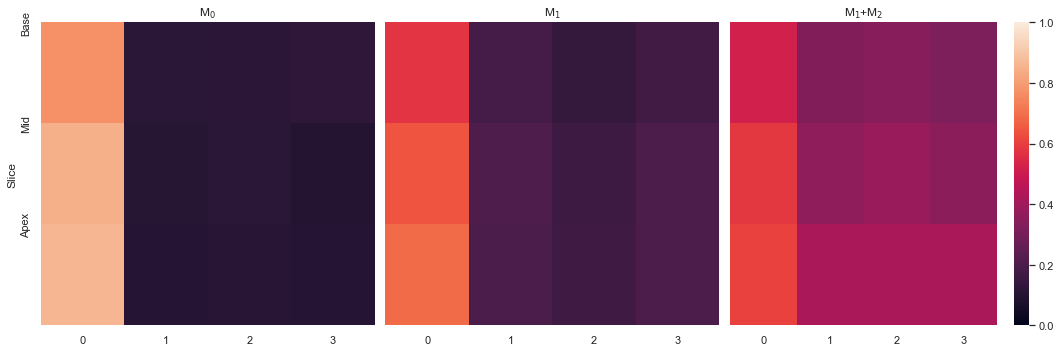

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot heatmaps
sns.heatmap(np.flip(np.nanmean(M0_avg_mean, axis=-1),axis = 0), vmin=0, vmax=1, ax=axes[0], cbar=False)
sns.heatmap(np.flip(np.nanmean(M1_avg_mean, axis=-1),axis = 0), vmin=0, vmax=1, ax=axes[1] ,cbar=False)
sns.heatmap(np.flip(np.nanmean(M2_avg_mean, axis=-1),axis = 0), vmin=0, vmax=1, ax=axes[2])

# Set titles for each subplot
axes[0].set_title('M$_0$')
axes[1].set_title('M$_1$')
axes[2].set_title('M$_1$+M$_2$')

# Set common y-axis label
axes[0].set_ylabel('Slice')

# Set custom y-ticks
axes[0].set_yticks([0, M0_avg_mean.shape[0]//2, M0_avg_mean.shape[0]-1])
axes[0].set_yticklabels(['Base', 'Mid', 'Apex'])

# Set custom x-ticks



# Display the plot
plt.tight_layout()
plt.show()

In [13]:
data

memmap([[[[ 0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j, ...,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j],
          [ 0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j, ...,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j],
          [ 0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j, ...,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j]],

         [[ 0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j, ...,
            0.00000000e+00+0.00000000e+00j,
       

# ADC Complex Average vs. Magnitude

In [14]:
M0_mask.shape,adc_mag_M0.shape

((128, 100, 3, 10), (128, 100, 3, 10))

In [15]:

adc_mag_M0 = adc_mag_M0 *M0_mask
adc_mag_M1 = adc_mag_M1 *M1_mask
adc_mag_M2 = adc_mag_M2 *M2_mask

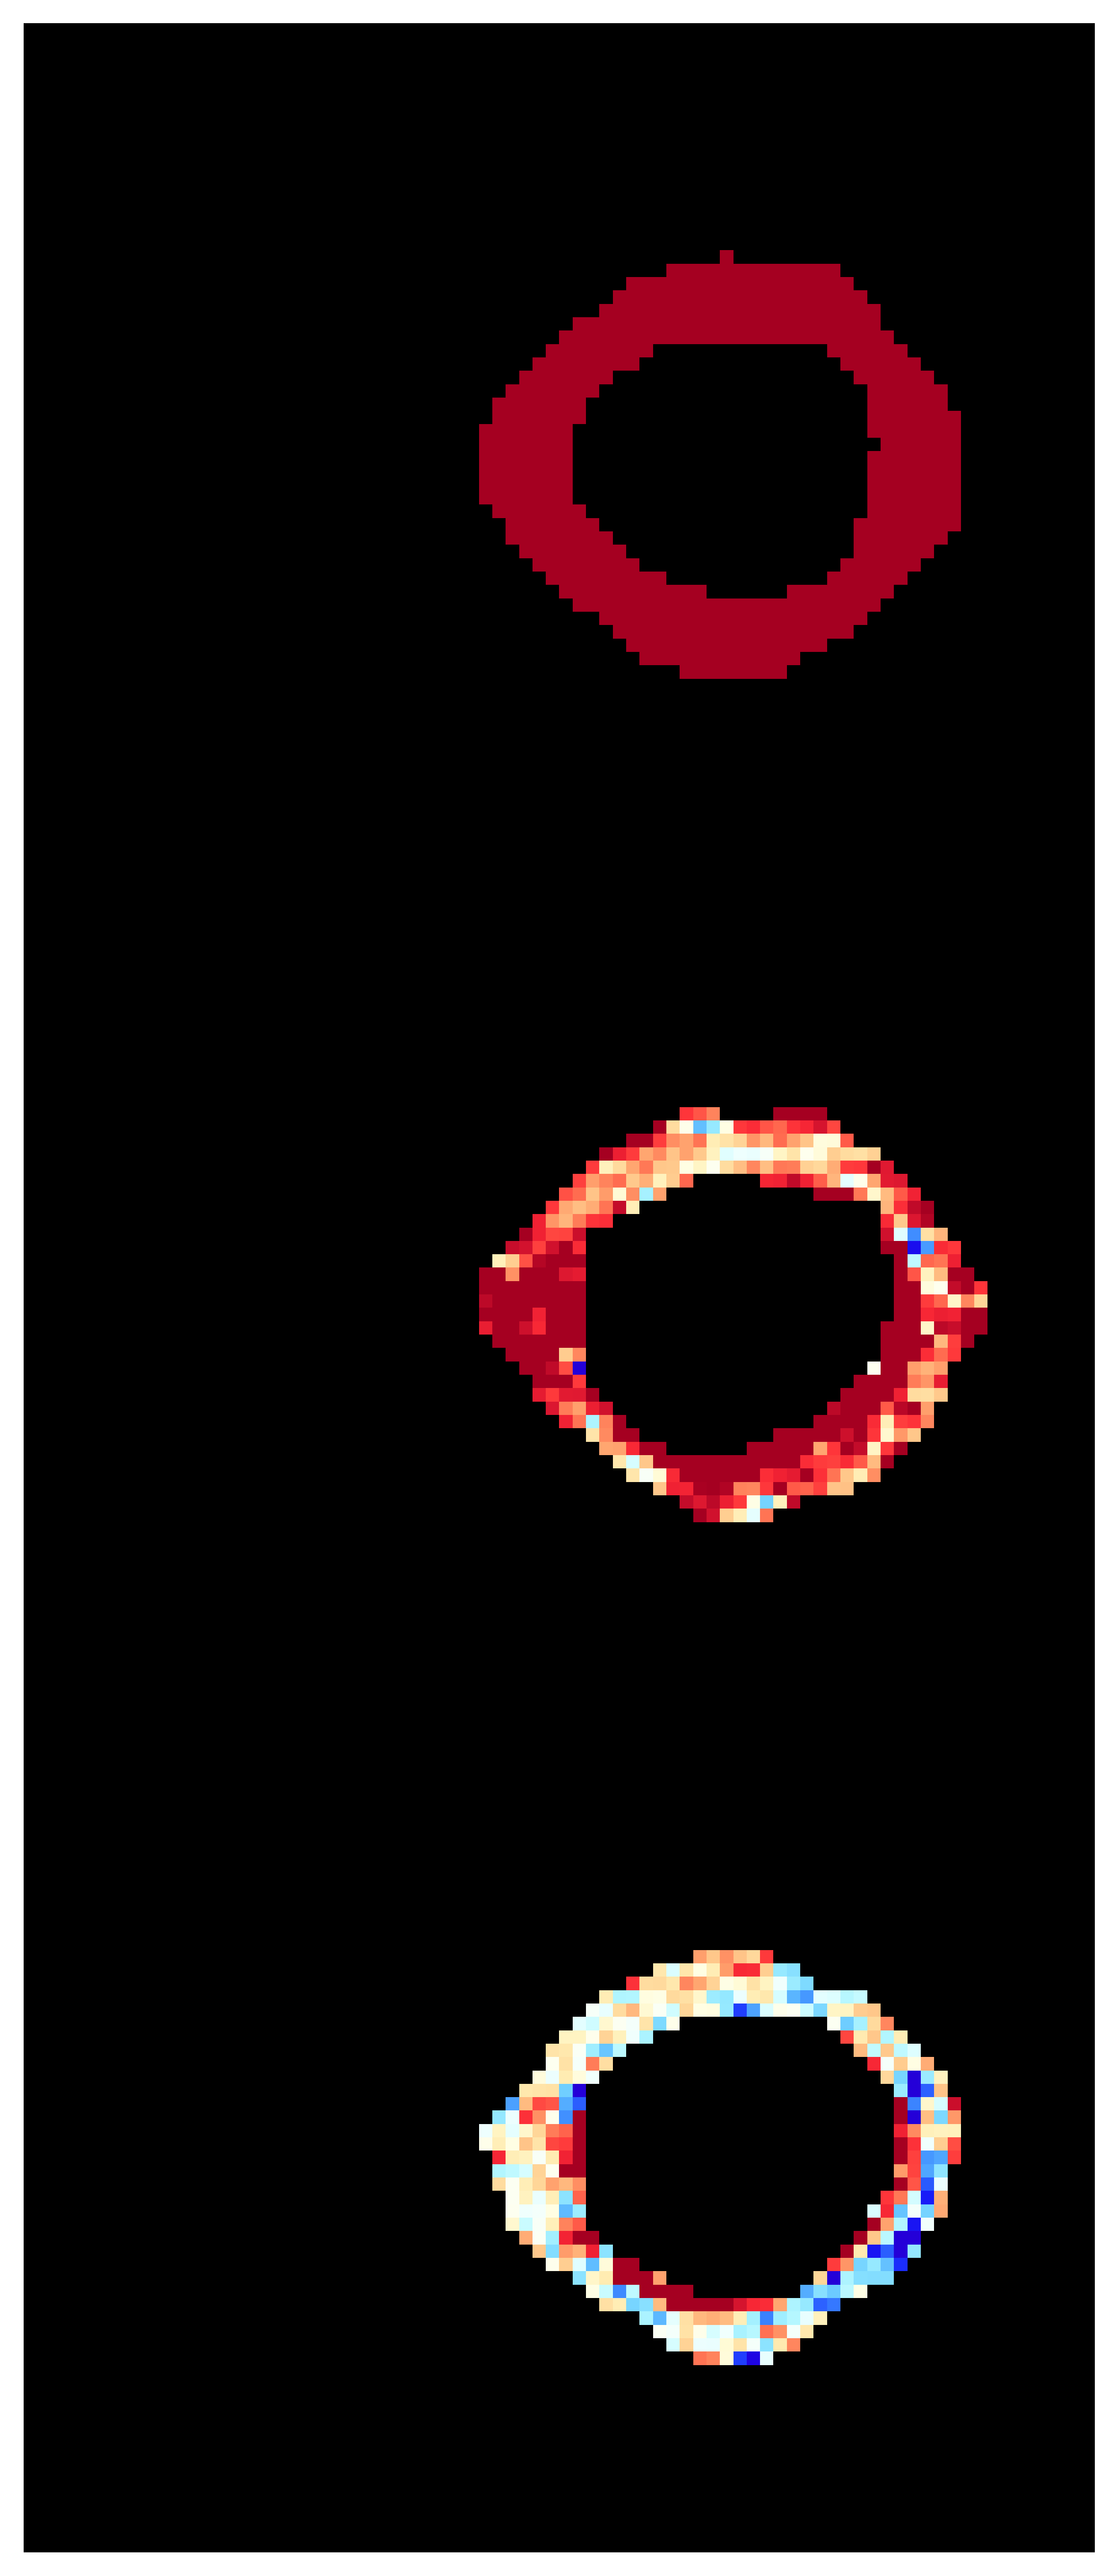

In [16]:
sl = 1
diffusion = -1 # diffusion direction [0, X [1], Y[2], Z[3]]
rep = -2
td = 2
volunteer = 5



fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(5,11), dpi=500)

w1 = 17 
w2 = 80
l1= 0
l2 = 80



M0_im = abs(averaged_mag_M0[:,:,sl,diffusion,volunteer])
M1_im = abs(averaged_mag_M1[:,:,sl,diffusion,volunteer])
M2_im = abs(averaged_mag_M2[:,:,sl,diffusion,volunteer])


### Get magnitude images
for ii in range(1):
    axes[0].imshow(M0_im[w1:w2,l1:l2],vmin = 0,vmax = 120,cmap = 'gray',interpolation = 'nearest')
    axes[1].imshow(M1_im[w1:w2,l1:l2],vmin = 0,vmax = 120,cmap = 'gray',interpolation = 'nearest')
    im0=axes[2].imshow(M2_im[w1:w2,l1:l2],vmin = 0,vmax = 120,cmap = 'gray',interpolation = 'nearest')


"""

row = 0
color = cDTI_cmaps['MD']

im_m0 = abs(adc_mag_M0[:,:,sl,volunteer] *M0_mask[:,:,sl,volunteer])
im_m1 =  abs(adc_mag_M1[:,:,sl,volunteer] *M1_mask[:,:,sl,volunteer])
im_m2 =  abs( adc_mag_M2[:,:,sl,volunteer]*M2_mask[:,:,sl,volunteer])
axes[row,0].imshow(im_m0[w1:w2,l1:l2],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
axes[row,1].imshow(im_m1[w1:w2,l1:l2],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
im4=axes[row,2].imshow(im_m2[w1:w2,l1:l2],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
axes[row,0].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[row,1].imshow(get_edge(np.nan_to_num(M1_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[row,2].imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')



row = 1
"""
vmax = 3
color = cDTI_cmaps['MD']
im_m0 = np.real(adc_complex_M0[:,:,sl,volunteer] *M0_mask[:,:,sl,volunteer])
im_m1 =   np.real(adc_complex_M1[:,:,sl,volunteer] *M1_mask[:,:,sl,volunteer])
im_m2 =   np.real(adc_complex_M2[:,:,sl,volunteer]*M2_mask[:,:,sl,volunteer])

axes[0].imshow(im_m0[w1:w2,l1:l2],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
axes[1].imshow(im_m1[w1:w2,l1:l2],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
im4=axes[2].imshow(im_m2[w1:w2,l1:l2],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
axes[0].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[1].imshow(get_edge(np.nan_to_num(M1_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[2].imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')





for ii in range(2):
    for jj in range(3):
        axes[jj].axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace =-0.0)



y=0.00x+1.55,R$^2$=0.00


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

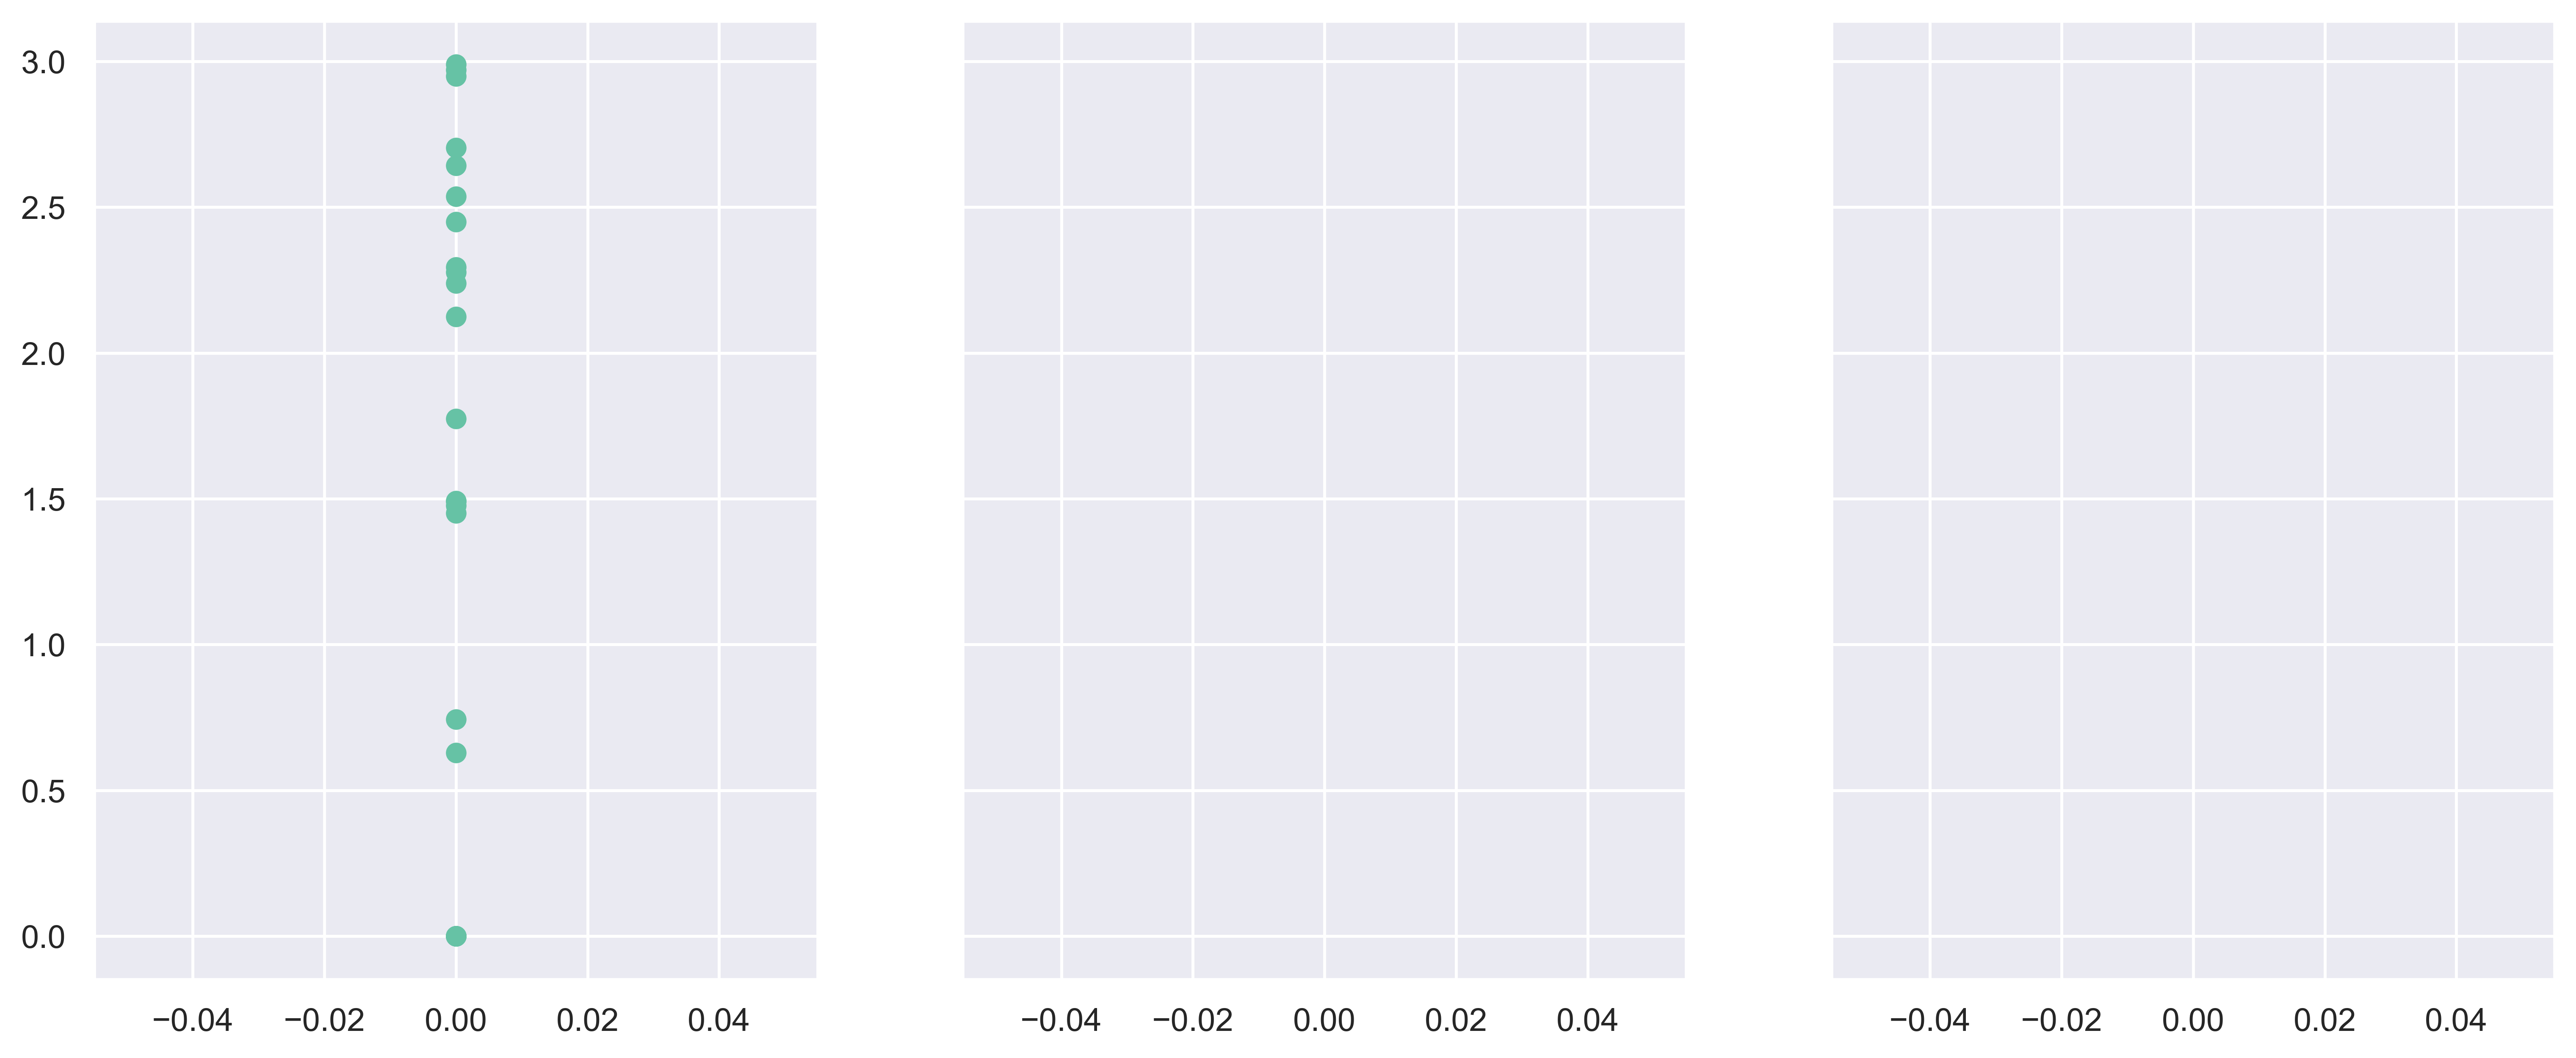

In [17]:
from sklearn.linear_model import LinearRegression
sl = 1
td = 1
colors = sns.color_palette("Set2",3)
fig, axes = plt.subplots(1, 3, figsize=(15,6),sharex=True,sharey = True,dpi=500)
# all pixels


input = adc_mag_M0[:,:,sl,  :]
dimX,dimY,volunteers= input.shape
xx = adc_mag_M0[:,:,sl,  :].reshape([dimX*dimY*volunteers])
yy = adc_complex_M0[:,:,sl,  :].reshape([dimX*dimY*volunteers])
valid_indices = ~np.isnan(xx) & ~np.isnan(yy)& (xx <= 3)  & (yy <= 3)  
xx_filtered = xx[valid_indices]
yy_filtered = yy[valid_indices]

axes[0].scatter(xx_filtered,yy_filtered, color = colors[0])



# Linear regression
model = LinearRegression()
model.fit(xx_filtered.reshape(-1, 1), yy_filtered)
# Get the slope and intercept
slope = model.coef_[0]
intercept = model.intercept_
r_squared = model.score(xx_filtered.reshape(-1, 1), yy_filtered)
# Plot line of best fit
x_values = np.linspace(np.min(xx_filtered), np.max(xx_filtered), 100)
y_values = slope * x_values + intercept
axes[0].plot(x_values, y_values, color='black', linestyle='--', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
print('y={:.2f}x+{:.2f},R$^2$={:.2f}'.format(slope,intercept,r_squared))



input = adc_mag_M0[:,:,sl,  :]
dimX,dimY,volunteers= input.shape
xx = adc_mag_M1[:,:,sl, :].reshape([dimX*dimY*volunteers])
yy = adc_complex_M1[:,:,sl, :].reshape([dimX*dimY*volunteers])
valid_indices = ~np.isnan(xx) & ~np.isnan(yy) & (xx <= 3)  & (yy <= 3)  & (xx > 0)  &  (yy > 0)
xx_filtered = xx[valid_indices]
yy_filtered = yy[valid_indices]



axes[1].scatter(xx_filtered,yy_filtered, color = colors[1])
# Linear regression
model = LinearRegression()
model.fit(xx_filtered.reshape(-1, 1), yy_filtered)
# Get the slope and intercept
slope = model.coef_[0]
intercept = model.intercept_
r_squared = model.score(xx_filtered.reshape(-1, 1), yy_filtered)
# Plot line of best fit
x_values = np.linspace(np.min(xx_filtered), np.max(xx_filtered), 100)
y_values = slope * x_values + intercept
axes[1].plot(x_values, y_values, color='black', linestyle='--', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
print('y={:.2f}x+{:.2f},R$^2$={:.2f}'.format(slope,intercept,r_squared))



input = adc_mag_M0[:,:,sl, :]
dimX,dimY,volunteers= input.shape
xx = adc_mag_M2[:,:,sl,  :].reshape([dimX*dimY*volunteers])
yy = adc_complex_M2[:,:,sl,  :].reshape([dimX*dimY*volunteers])
valid_indices = ~np.isnan(xx) & ~np.isnan(yy) & (xx <= 3)  & (yy <= 3)  
xx_filtered = xx[valid_indices]
yy_filtered = yy[valid_indices]

axes[2].scatter(xx_filtered,yy_filtered, color = colors[2])
# Linear regression
model = LinearRegression()
model.fit(xx_filtered.reshape(-1, 1), yy_filtered)
# Get the slope and intercept
slope = model.coef_[0]
intercept = model.intercept_
r_squared = model.score(xx_filtered.reshape(-1, 1), yy_filtered)
# Plot line of best fit
x_values = np.linspace(np.min(xx_filtered), np.max(xx_filtered), 100)
y_values = slope * x_values + intercept
axes[2].plot(x_values, y_values, color='black', linestyle='--', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
print('y={:.2f}x+{:.2f},R$^2$={:.2f}'.format(slope,intercept,r_squared))


for ii in range(3):
    axes[ii].set_xlabel('Magnitude Averaging')
    axes[ii].set_ylabel('Complex Averaging')


plt.tight_layout()
plt.show()

In [ ]:
yy_filtered.shape

(5236,)

In [ ]:
adc_mag_M0[adc_mag_M0>3] = np.nan
adc_mag_M1[adc_mag_M1>3] = np.nan
adc_mag_M2[adc_mag_M2>3] = np.nan
# ADC Complex Average vs. Magnitude
adc_complex_M0[adc_complex_M0>3] = np.nan
adc_complex_M1[adc_complex_M1>3] = np.nan
adc_complex_M2[adc_complex_M2>3] = np.nan

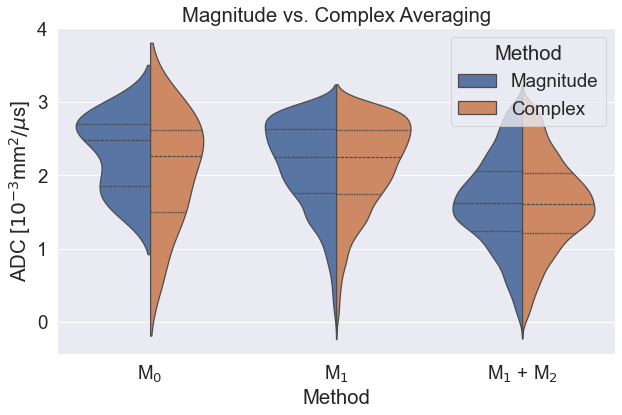

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sl = 1
td = 6
sns.set_palette('colorblind')
sns.set(font_scale=1.7) 
# Function to flatten and pad arrays to the same size, excluding values > 3 or == 0
def flatten_and_pad(array, target_size):
    flat_array = array.ravel()
    flat_array = flat_array[(flat_array <= 3) & (flat_array != 0)]  # Filter values
    padding = np.full(target_size - len(flat_array), np.nan)
    return np.concatenate([flat_array, padding])

# Prepare data for DataFrame
data = {
    'Method': ['Magnitude'] * adc_mag_M0[:,:,sl,:].size +
              ['Complex'] * adc_complex_M0[:,:,sl,:].size +
              ['Magnitude'] * adc_mag_M1[:,:,sl,:].size +
              ['Complex'] * adc_complex_M1[:,:,sl,:].size +
              ['Magnitude'] * adc_mag_M2[:,:,sl,:].size +
              ['Complex'] * adc_complex_M2[:,:,sl,:].size,
    'Value': np.concatenate([
        flatten_and_pad(adc_mag_M0[:,:,sl,:]*M0_mask[:,:,sl,:], adc_mag_M0[:,:,sl,:].size),
        flatten_and_pad(adc_complex_M0[:,:,sl,:]*M0_mask[:,:,sl,:], adc_complex_M0[:,:,sl,:].size),
        flatten_and_pad(adc_mag_M1[:,:,sl,:]*M1_mask[:,:,sl,:], adc_mag_M1[:,:,sl,:].size),
        flatten_and_pad(adc_complex_M1[:,:,sl,:]*M1_mask[:,:,sl,:], adc_complex_M1[:,:,sl,:].size),
        flatten_and_pad(adc_mag_M2[:,:,sl,:]*M2_mask[:,:,sl,:], adc_mag_M2[:,:,sl,:].size),
        flatten_and_pad(adc_complex_M2[:,:,sl,:]*M2_mask[:,:,sl,:], adc_complex_M2[:,:,sl,:].size)
    ]),
    'Case': ['M$_0$'] * (adc_mag_M0[:,:,sl,:].size + adc_complex_M0[:,:,sl,:].size) + 
            ['M$_1$'] * (adc_mag_M1[:,:,sl,:].size + adc_complex_M1[:,:,sl,:].size) + 
            ['M$_1$ + M$_2$'] * (adc_mag_M2[:,:,sl,:].size + adc_complex_M2[:,:,sl,:].size)
}

# Create DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="Case", y="Value", hue="Method", split=True, inner="quart")
plt.xlabel('Method')
plt.ylabel('ADC [$10^{-3}$mm$^2/µ$s]')
plt.title('Magnitude vs. Complex Averaging')
plt.show()


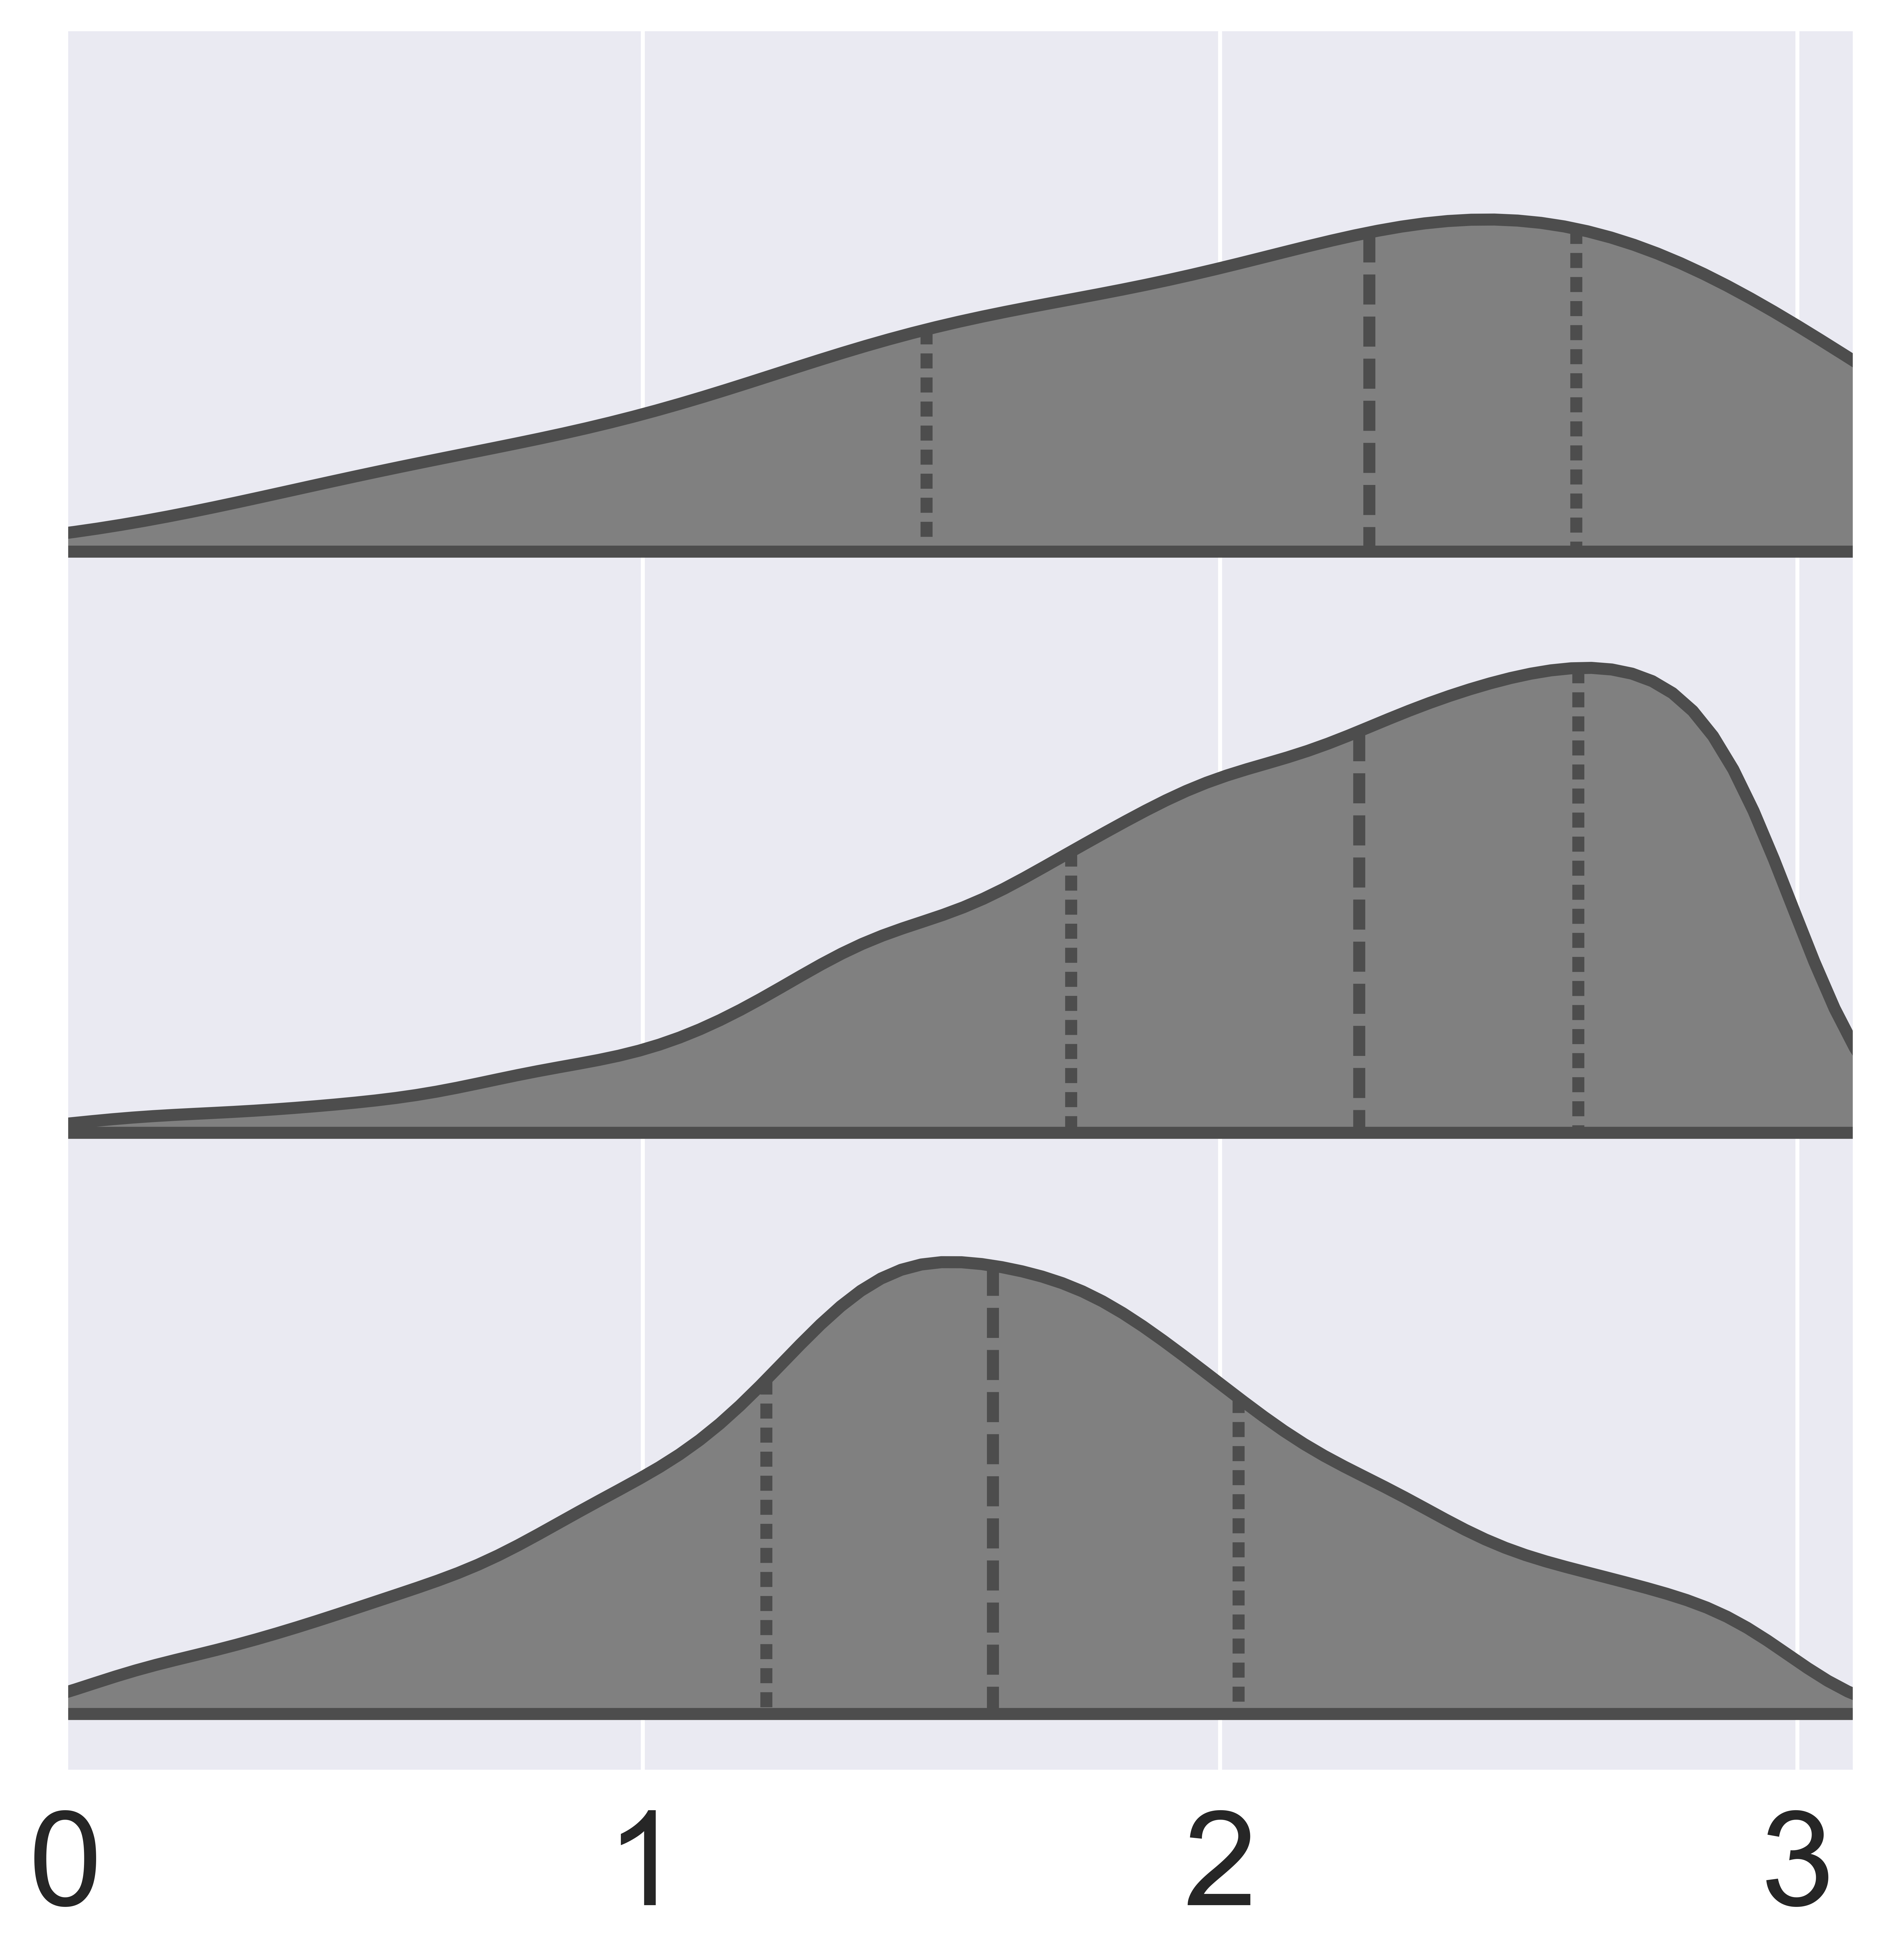

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sl = 1
td = 6
sns.set_palette('colorblind')
sns.set(font_scale=3) 
# Function to flatten and pad arrays to the same size, excluding values > 3 or == 0
def flatten_and_pad(array, target_size):
    flat_array = array.ravel()
    flat_array = flat_array[(flat_array <= 3) & (flat_array != 0)]  # Filter values
    padding = np.full(target_size - len(flat_array), np.nan)
    return np.concatenate([flat_array, padding])

# Prepare data for DataFrame
data = {
    'Method':
              ['Complex'] * adc_complex_M0[:,:,sl,:].size +
              
              ['Complex'] * adc_complex_M1[:,:,sl,:].size +
              
              ['Complex'] * adc_complex_M2[:,:,sl,:].size,
    'Value': np.concatenate([
        
        flatten_and_pad(adc_complex_M0[:,:,sl,:]*M0_mask[:,:,sl,:], adc_complex_M0[:,:,sl,:].size),
       
        flatten_and_pad(adc_complex_M1[:,:,sl,:]*M1_mask[:,:,sl,:], adc_complex_M1[:,:,sl,:].size),
        
        flatten_and_pad(adc_complex_M2[:,:,sl,:]*M2_mask[:,:,sl,:], adc_complex_M2[:,:,sl,:].size)
    ]),
    'Case': ['M$_0$'] * (adc_complex_M0[:,:,sl,:].size) + 
            ['M$_1$'] * (adc_complex_M1[:,:,sl,:].size) + 
            ['M$_1$ + M$_2$'] * ( adc_complex_M2[:,:,sl,:].size)
}

# Create DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(8, 8),dpi = 1000)
sns.violinplot(data=df, y="Case", x="Value", split= True,  inner="quart",orient  = 'h' , linewidth =3,color = 'gray')
plt.ylabel('',size = 1)
plt.xlabel('',size = 1)
plt.yticks([])
plt.xticks([0,1,2,3,4])
plt.xlim([0,3.1])
plt.show()

median_value = df['Value'].median()


In [68]:
median_per_group = df.groupby('Case')['Value'].median()
print("Median value for each group:")
print(median_per_group)

Median value for each group:
Case
M$_0$            2.258047
M$_1$            2.240718
M$_1$ + M$_2$    1.606196
Name: Value, dtype: float64


In [ ]:
test =  np.concatenate([
        
        flatten_and_pad(adc_complex_M0[:,:,sl,:]*M0_mask[:,:,sl,:], adc_complex_M0[:,:,sl,:].size), ] 
)

print(np.nanmedian(test))


test =  np.concatenate([
        
        flatten_and_pad(adc_complex_M1[:,:,sl,:]*M1_mask[:,:,sl,:], adc_complex_M1[:,:,sl,:].size), ] 
)

print(np.nanmedian(test))


test =  np.concatenate([
        
        flatten_and_pad(adc_complex_M2[:,:,sl,:]*M2_mask[:,:,sl,:], adc_complex_M2[:,:,sl,:].size), ] 
)

print(np.nanmedian(test))

2.2580473592719494
2.240718465447563
1.6061959309407554


In [ ]:


# Define your data sets here (replace with your actual data)
data_sets = [
    flatten_and_pad(adc_complex_M0[:,:,sl,:]*M0_mask[:,:,sl,:], adc_complex_M0[:,:,sl,:].size),
    flatten_and_pad(adc_complex_M1[:,:,sl,:]*M0_mask[:,:,sl,:], adc_complex_M1[:,:,sl,:].size),
    flatten_and_pad(adc_complex_M2[:,:,sl,:]*M0_mask[:,:,sl,:], adc_complex_M2[:,:,sl,:].size)
]

# Calculate 95% confidence intervals for each data set
for i, data in enumerate(data_sets):
    lower_percentile = np.nanpercentile(data, 2.5)
    upper_percentile = np.nanpercentile(data, 97.5)
    lower_percentile = round(lower_percentile, 2)
    upper_percentile = round(upper_percentile, 2)
    print(f"95% Confidence Interval for Test {i + 1}: [{lower_percentile}, {upper_percentile}]")

95% Confidence Interval for Test 1: [0.68, 2.98]
95% Confidence Interval for Test 2: [0.61, 2.96]
95% Confidence Interval for Test 3: [0.29, 2.83]


In [21]:
adc_complex_M0.shape

med_adc_complex_M0 = adc_complex_M0 #np.nanmean(adc_complex_M0,axis = (0,1))
med_adc_complex_M1 = adc_complex_M1 #np.nanmean(adc_complex_M1,axis = (0,1))
med_adc_complex_M2 = adc_complex_M2 #np.nanmean(adc_complex_M2,axis = (0,1))

std_all = np.stack((med_adc_complex_M0,med_adc_complex_M1,med_adc_complex_M2),axis = -1)
std_all.shape

alpha = 0.5


import scikit_posthocs as sp
from scipy import stats
group1 = std_all[:,:,:,:,0].reshape((3*10*128*100))
group2 = std_all[:,:,:,:,1].reshape((3*10*128*100))
group3 = std_all[:,:,:,:,2].reshape((3*10*128*100))

normal = 0 if stats.shapiro(group1)[1] <alpha or stats.shapiro(group2)[1] <alpha or stats.shapiro(group1)[1] <alpha else 1

if normal ==0:
    result = stats.friedmanchisquare(group1, group2, group3)
    if result[1] < alpha:
        test = sp.posthoc_wilcoxon([group1,group2,group3],p_adjust = 'holm-sidak')
        hypothesis = test
    else:
        hypothesis = np.nan

elif normal ==1:
    result = stats.f_oneway(group1, group2, group3)
    if result[1] < alpha:
        test = sp.posthoc_ttest([group1,group2,group3],p_adjust = 'holm-sidak')
        hypothesis= test 
    else:
        hypothesis = np.nan

hypothesis

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


nan

In [56]:
test

,1,2,3
1,1.0,0.000000e+00,0.000000e+00
2,0.0,1.000000e+00,8.112146e-216
3,0.0,8.112146e-216,1.000000e+00


In [53]:
import numpy as np
import scikit_posthocs as sp
from scipy import stats

# Assuming adc_complex_M0, adc_complex_M1, and adc_complex_M2 are your original arrays

# Combine all arrays into a single array
combined_array = np.stack((adc_complex_M0, adc_complex_M1, adc_complex_M2), axis=-1)

# Iterate over each array and filter NaNs
for i in range(3):
    nan_indices = np.isnan(combined_array[..., i])
    combined_array[nan_indices,:] = np.nan

# Separate arrays
med_adc_complex_M0 = combined_array[..., 0]
med_adc_complex_M1 = combined_array[..., 1]
med_adc_complex_M2 = combined_array[..., 2]

# Reshape the groups
group1 = med_adc_complex_M0.reshape((-1,))
group2 = med_adc_complex_M1.reshape((-1,))
group3 = med_adc_complex_M2.reshape((-1,))

group1 = group1[~np.isnan(group1)]
group2 = group2[~np.isnan(group2)]
group3 = group3[~np.isnan(group3)]



alpha = 0.5
normal = 0 if stats.shapiro(group1)[1] < alpha or stats.shapiro(group2)[1] < alpha or stats.shapiro(group3)[1] < alpha else 1

if normal == 0:
    result = stats.friedmanchisquare(group1, group2, group3)
    if result[1] < alpha:
        test = sp.posthoc_wilcoxon([group1, group2, group3], p_adjust='holm-sidak')
        hypothesis = test
    else:
        hypothesis = np.nan
elif normal == 1:
    result = stats.f_oneway(group1, group2, group3)
    if result[1] < alpha:
        test = sp.posthoc_ttest([group1, group2, group3], p_adjust='holm-sidak')
        hypothesis = test
    else:
        hypothesis = np.nan

result

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


FriedmanchisquareResult(statistic=41174.73232906693, pvalue=0.0)

In [55]:
result.pvalue

0.0

In [51]:
group1[group1==np.nan] = np.nan
group1.shape

(384000,)

In [73]:
adc_complex_M0.shape

med_adc_complex_M0 = np.nanmean(adc_complex_M0,axis = (0,1,2))
med_adc_complex_M1 = np.nanmean(adc_complex_M1,axis = (0,1,2))
med_adc_complex_M2 = np.nanmean(adc_complex_M2,axis = (0,1,2))

std_all = np.stack((med_adc_complex_M0,med_adc_complex_M1,med_adc_complex_M2),axis = -1)
std_all.shape

alpha = 0.5


import scikit_posthocs as sp
from scipy import stats
group1 = std_all[:,0]
group2 = std_all[:,1]
group3 = std_all[:,2]

normal = 0 if stats.shapiro(group1)[1] <alpha or stats.shapiro(group2)[1] <alpha or stats.shapiro(group1)[1] <alpha else 1

if normal ==0:
    result = stats.friedmanchisquare(group1, group2, group3)
    if result[1] < alpha:
        test = sp.posthoc_wilcoxon([group1,group2,group3],p_adjust = 'holm-sidak')
        hypothesis = test
    else:
        hypothesis = np.nan

elif normal ==1:
    result = stats.f_oneway(group1, group2, group3)
    if result[1] < alpha:
        test = sp.posthoc_ttest([group1,group2,group3],p_adjust = 'holm-sidak')
        hypothesis= test 
    else:
        hypothesis = np.nan

hypothesis

,1,2,3
1,1.000000,0.005848,0.005848
2,0.005848,1.000000,0.322266
3,0.005848,0.322266,1.000000


In [61]:
group1

array([2.38845724, 2.03547546, 2.37485329, 2.52899879, 2.60685796,
       2.54498784, 1.68415178, 1.82380133, 2.72377969, 1.92496014])

In [62]:
group2

array([1.958799  , 1.52758319, 1.97725784, 2.11982349, 2.12541269,
       2.07192217, 1.51201383, 1.59013934, 2.20743116, 1.56792719])

In [63]:
group3

array([1.61594368, 1.72351708, 1.74586051, 1.99768784, 2.15787938,
       1.95167038, 1.67514404, 1.45602787, 2.09466931, 1.55578008])

In [71]:
median_per_group = df.groupby('Case')['Value'].median()
print("Median value for each group:")
print(median_per_group)
percentiles_per_group = df.groupby('Case')['Value'].quantile([0.25, 0.75])

Median value for each group:
Case
M$_0$            2.258047
M$_1$            2.240718
M$_1$ + M$_2$    1.606196
Name: Value, dtype: float64


In [72]:
percentiles_per_group

Case               
M$_0$          0.25    1.491336
               0.75    2.616846
M$_1$          0.25    1.741625
               0.75    2.620166
M$_1$ + M$_2$  0.25    1.213644
               0.75    2.031842
Name: Value, dtype: float64